1. Import ML Packages (Tensorflow, MatPlotLib, etc.)

In [3]:
# for displaying data in plots
import matplotlib.pyplot as plt
import numpy as np

# imaging Librarys for opening, changing, and saving many image file formats
import PIL

# machine learning package
import tensorflow as tf
# keras: interface for deep learning (artificial neural networks)
from tensorflow import keras

# layers: basic building blocks of neural networks. Consists of a tensor-in tensor-out computation function (the layer's call method) 
# and some state, held in TensorFlow variables (the layer's weights).
from keras import layers
# sequential: plain stack of layers where each layer has exactly one input tensor and one output tensor
from keras.models import Sequential 

2. Get Dataset

In [4]:
# library for working with files and directories
import pathlib

# Using the image scraper, all images were downloaded into the dataset folder
data_dir = pathlib.WindowsPath('C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/Dataset')
print(type(data_dir))

<class 'pathlib.WindowsPath'>


In [5]:
# display how many images you have in total
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5977


3. Load Data and Convert Into Tensorflow Dataset

In [6]:
# designate image height and width
batch_size = 32
img_height = 180
img_width = 180

In [9]:
# keras.util: set of simple helpers for Keras
# image_dataset_from_directory: creates a tensorflow tf.data.Dataset from image files in a directory

# validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
  # 20% reserved for validation, 80% reserved for training
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 5977 files belonging to 4 classes.
Using 4782 files for training.


In [10]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5977 files belonging to 4 classes.
Using 1195 files for validation.


In [12]:
class_names = train_ds.class_names

# display all classifications: poison oak, poison ivy, not any of the 3, poison sumac
print(class_names)

['Atlantic_Poison_Oak', 'Eastern_Poison_Ivy', 'Not', 'Poison_Sumac']


4. Prepare Dataset for Peformance

In [14]:
# AUTOTUNE: prompt the tf.data runtime to tune the value dynamically at runtime
AUTOTUNE = tf.data.AUTOTUNE

# .cache: keeps the images in memory after they're loaded off disk during the first epoch
# .shuffle: shuffles the samples to always have a random order of samples fed to the network
# .prefetch: overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

5. Standardize the Data

In [19]:
# The RGB channel values are in the [0, 255] range, which is is not ideal for a neural network; in general, make your input values small
# tf.keras.layers.Rescaling: standardize values to be in the [0, 1] range
normalization_layer = layers.Rescaling(1./255)

In [21]:
# standardizing the dataset to be [0, 1]
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# iterator for normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# get the first image
first_image = image_batch[0]

# Range is [0,1]
print(np.min(first_image), np.max(first_image))

0.0 0.9926471


6. Create Keras Model

In [24]:
# keep track of # classes
num_classes = len(class_names)

# creating sequential model
model = Sequential([ 
  # rescaling: rescales input values to a be [0, 1] range
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # conv2D: a layer that creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # maxpooling2D: Downsamples the input along its spatial dimensions (height and width) 
  # by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Flattens the input. Does not affect the batch size
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

7. Compile the model

In [25]:
# compile: configures the model for training
# adam = adam's replacement optimization algorithm for stochastic gradient descent for training deep learning models
model.compile(optimizer = 'adam',
              # Computes the crossentropy loss between the labels and predictions. Used when there are 2+ label classes
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

8. Model Summary

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

9. Training the Model

In [27]:
#Train the model for 10 epochs
epochs = 10

history = model.fit(
  train_ds,
  validation_data = val_ds,
  # epochs:  number of epochs means how many times you go through your training set. The model is updated each time a batch is processed
  epochs = epochs
)

Epoch 1/10
150/150 [==============================] - 107s 682ms/step - loss: 1.2344 - accuracy: 0.4969 - val_loss: 1.1457 - val_accuracy: 0.5121
Epoch 2/10
150/150 [==============================] - 91s 609ms/step - loss: 1.0974 - accuracy: 0.5487 - val_loss: 1.0662 - val_accuracy: 0.5556
Epoch 3/10
150/150 [==============================] - 89s 592ms/step - loss: 1.0223 - accuracy: 0.5765 - val_loss: 1.0445 - val_accuracy: 0.5556
Epoch 4/10
150/150 [==============================] - 88s 587ms/step - loss: 0.9372 - accuracy: 0.6169 - val_loss: 1.0178 - val_accuracy: 0.5799
Epoch 5/10
150/150 [==============================] - 88s 590ms/step - loss: 0.8321 - accuracy: 0.6625 - val_loss: 1.0564 - val_accuracy: 0.5699
Epoch 6/10
150/150 [==============================] - 88s 587ms/step - loss: 0.6526 - accuracy: 0.7424 - val_loss: 1.1837 - val_accuracy: 0.5665
Epoch 7/10
150/150 [==============================] - 87s 577ms/step - loss: 0.4755 - accuracy: 0.8170 - val_loss: 1.3801 - val_a

10. Visualize the Accuracy

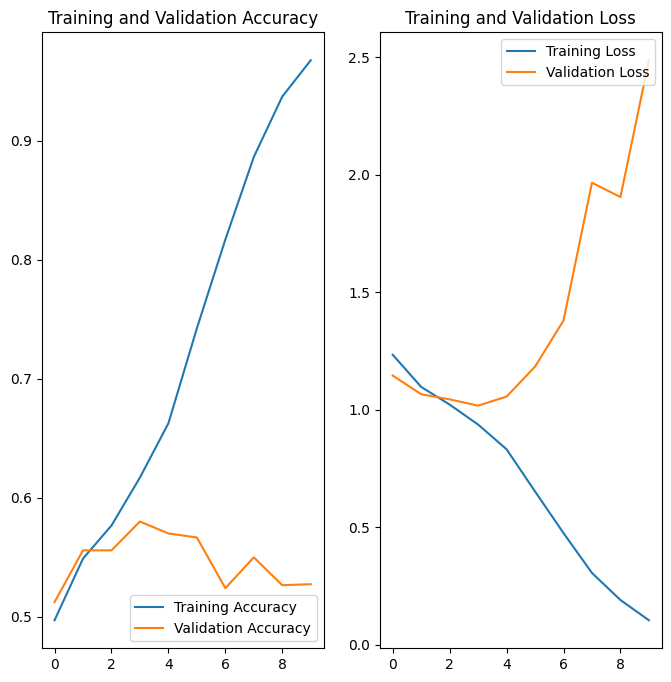

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

11. Fixing Overfitting with Data Augmentation

In [30]:
# the drastic difference in accuracy between training and validation accuracy is noticeable. This is Overfitting
# Overfitting: When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples
# Solution: takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images
# This helps expose the model to more aspects of the data and generalize better.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

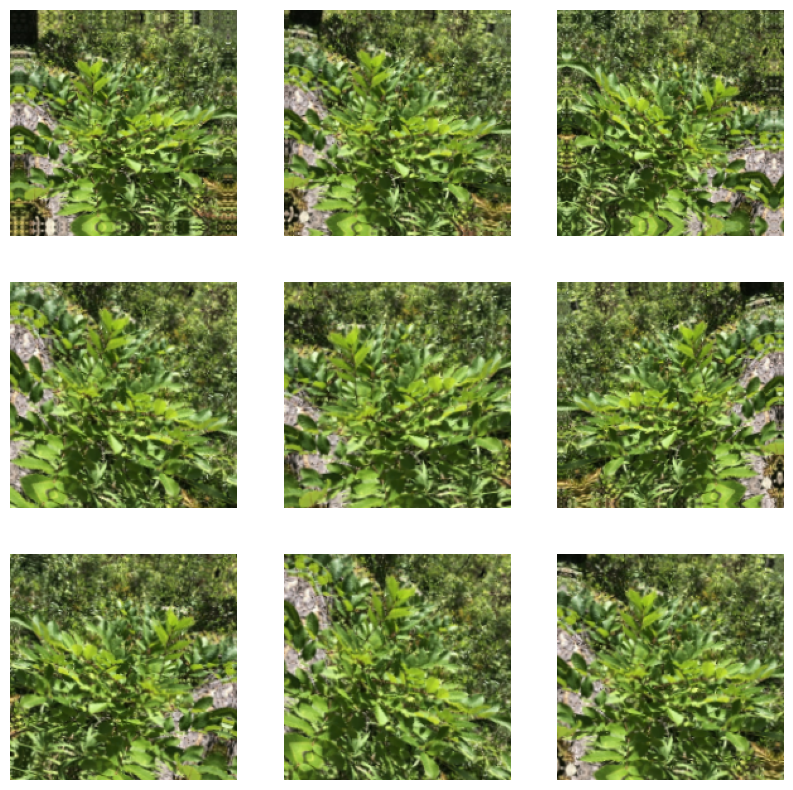

In [31]:
# plotting a new figure
plt.figure(figsize = (10, 10))

# Visualize a few augmented examples by applying data augmentation to the same image several times
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

12. Fixing Overfiting with Dropout

In [32]:
# When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [33]:
# recompile the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [34]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [35]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
150/150 [==============================] - 111s 705ms/step - loss: 1.2768 - accuracy: 0.4946 - val_loss: 1.1680 - val_accuracy: 0.5188
Epoch 2/15
150/150 [==============================] - 104s 690ms/step - loss: 1.1240 - accuracy: 0.5182 - val_loss: 1.1180 - val_accuracy: 0.5238
Epoch 3/15
150/150 [==============================] - 102s 683ms/step - loss: 1.0938 - accuracy: 0.5391 - val_loss: 1.0961 - val_accuracy: 0.5490
Epoch 4/15
150/150 [==============================] - 107s 715ms/step - loss: 1.0654 - accuracy: 0.5556 - val_loss: 1.0724 - val_accuracy: 0.5523
Epoch 5/15
150/150 [==============================] - 107s 708ms/step - loss: 1.0426 - accuracy: 0.5655 - val_loss: 1.0277 - val_accuracy: 0.5799
Epoch 6/15
150/150 [==============================] - 103s 689ms/step - loss: 1.0208 - accuracy: 0.5621 - val_loss: 1.0976 - val_accuracy: 0.5657
Epoch 7/15
150/150 [==============================] - 102s 680ms/step - loss: 1.0089 - accuracy: 0.5753 - val_loss: 1.0299 -

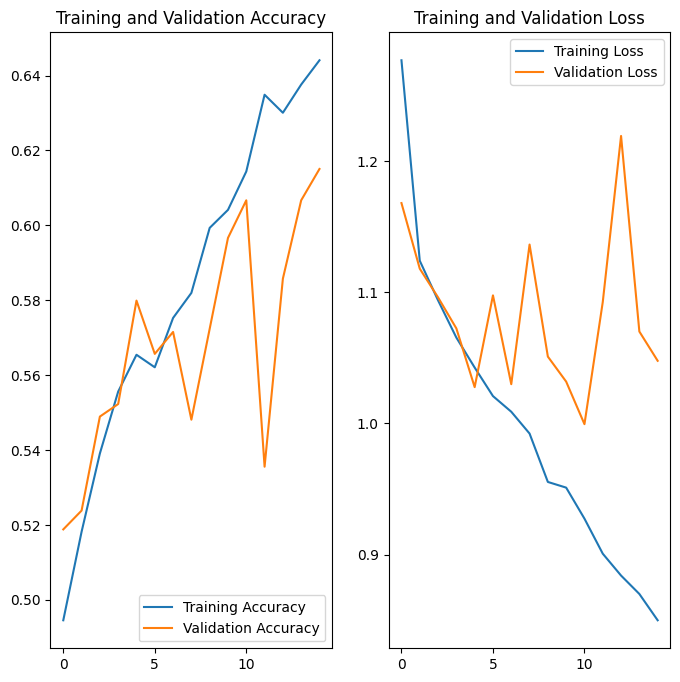

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

13. Testing model on new Data

In [41]:
coleus_path = 'C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/Dataset/Not/1402.jpg'

img = tf.keras.utils.load_img(
    coleus_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 5s 5s/step
This image most likely belongs to Not with a 76.09 percent confidence.
